In [15]:
import numpy as np
from tqdm import tqdm
import pandas as pd
import matplotlib.pyplot as plt
import pandas as pd


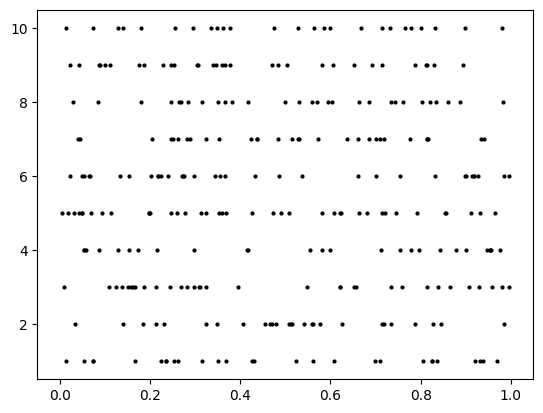

In [16]:
possion_file_path = "C:/Users/Micro/Desktop/MainResearch/SNN-deployment/network-simulation/data/logs/possion_input_30hz.v"

nt = 10000
dt = 1e-4
inputs = pd.read_csv(possion_file_path)
t = np.arange(nt)*dt
for col in range(len(inputs.columns) - 1):
    neuron_outputs = np.array([(int)(element) for element in (inputs.iloc[:,col + 1])], dtype=float) 
    
    plt.plot(t, neuron_outputs * (col + 1), 'ko', markersize=2)
    plt.ylim(0.5, len(inputs.columns) - 1  + 0.5)

In [25]:
connection_response_path = "C:/Users/Micro/Desktop/MainResearch/SNN-deployment/network-simulation/data/logs/full_connection_1.r"
response = pd.read_csv(connection_response_path)




In [18]:

class CurrentBasedLIF:
    def __init__(self, N, dt=1e-4, tref=5e-3, tc_m=1e-2, vrest=-60, vreset=-60, vthr=-50, vpeak=20):
        self.N = N
        self.dt = dt
        self.tref = tref
        self.tc_m = tc_m
        self.vrest = vrest
        self.vreset = vreset
        self.vthr = vthr
        self.vpeak = vpeak
        self.v = self.vreset * np.ones(N)
        self.v_ = None
        self.tlast = 0
        self.tcount = 0
    
    def initialize_states(self, random_state=False):
        if random_state:
            self.v = self.vreset + \
            np.random.rand(self.N)*(self.vthr-self.vreset)
        else:
            self.v = self.vreset*np.ones(self.N)
        self.tlast = 0
        self.tcount = 0
    
    def __call__(self, I):
        dv = (self.vrest - self.v + I) / self.tc_m
        v = self.v + (self.dt*self.tcount>(self.tlast+self.tref))*dv*self.dt

        s = 1 * (v >= self.vthr) #发火的情况下s = 1, 其余情况为0。

        self.tlast = self.tlast * (1 - s) + self.dt * self.tcount * s # 発火時刻の更新
        v = v * (1 - s) + self.vpeak * s # 若超过阈值则将膜电位设置为峰值电位
        self.v_ = v # 発火時の電位も含めて記録するための変数
        self.v = v * (1 - s) + self.vreset * s # 発火時に膜電位をリセット
        self.tcount += 1

        return s


class DoubleExponentialSynapse:
    def __init__(self, N, dt=1e-4, td=1e-2, tr=5e-3):
        self.N = N
        self.dt = dt
        self.td = td
        self.tr = tr
        self.r = np.zeros(N)
        self.hr = np.zeros(N)

    def initialize_states(self):
        self.r = np.zeros(self.N)
        self.hr = np.zeros(self.N)

    def __call__(self, spike, silent = True):
        
        if not silent:
            print(f"response r = {self.r} * (1 - {self.dt} / {self.tr}) + {self.hr} * {self.dt}")
            print(f"response hr = {self.hr} * (1 - {self.dt} / {self.td}) + {spike} / {self.tr} * {self.td} ")

        r = self.r*(1-self.dt/self.tr) + self.hr*self.dt
        hr = self.hr*(1-self.dt/self.td) + spike/(self.tr*self.td)
        if not silent:
            print(f"r = {r}, hr = {hr}")
        self.r = r
        self.hr = hr
        return r


np.random.seed(seed=0)

dt = 1e-4; T = 1; nt = 10000 # round(T/dt) # Simulation time
num_in = 10; num_out = 1 # input/output neuron amount

# input possion spike
fr_in = 30 # input possion spike発火率 (Hz)
x = np.array(inputs.iloc[:, 1:])[:nt]

W = np.array([-0.342278, -0.0406995, 0.106295,  -0.0634124, 0.0452562, -0.284242, -0.366801 , -0.0654828 , 0.230545 , 0.186644 ]).reshape((num_out, num_in)) # 0.2*np.random.randn(num_out, num_in) # random connection weight
x
# model
# output size, time delta, efactory time period (s), membrance time constance, Static membrane potential, reset potential, potential threashold, peak potential
neurons = CurrentBasedLIF(N=num_out, dt=dt, tref=5e-3, tc_m=1e-2, vrest=-65, vreset=-60, vthr=-40, vpeak=30)

synapses = DoubleExponentialSynapse(N=num_out, dt=dt, td=1e-2, tr=1e-2)
# 記録用配列
current = np.zeros((num_out, nt))
voltage = np.zeros((num_out, nt))
single_neuron_current = np.zeros((num_in, num_out, nt))


In [19]:
np.random.seed(seed=0)
W = 0.2*np.random.randn(num_out, num_in)
W

array([[ 0.35281047,  0.08003144,  0.1957476 ,  0.44817864,  0.3735116 ,
        -0.19545558,  0.19001768, -0.03027144, -0.02064377,  0.0821197 ]])

In [20]:

# Simulation
neurons.initialize_states() # init states
synapses = []
for i in range(num_in):
    synapse = DoubleExponentialSynapse(N=1, dt=dt, td=1e-2, tr=1e-2)
    synapses.append(synapse)

for t in tqdm(range(nt)):
    # update
    I = 0
    s = 0
    for synapse_id in range(num_in):
        response_input = W[0, synapse_id] * x[t][synapse_id]
        single_neuron_I = synapses[synapse_id](response_input, True)
        single_neuron_current[synapse_id, 0, t] = single_neuron_I
        I += single_neuron_I
    s = neurons(I)
    # record
    current[:, t] = I
    voltage[:, t] = neurons.v_

  0%|                                                                                        | 0/10000 [00:00<?, ?it/s]C:\Users\Micro\AppData\Local\Temp\ipykernel_10000\360544283.py:15: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  single_neuron_current[synapse_id, 0, t] = single_neuron_I
100%|██████████████████████████████████████████████████████████████████████████| 10000/10000 [00:01<00:00, 5031.28it/s]


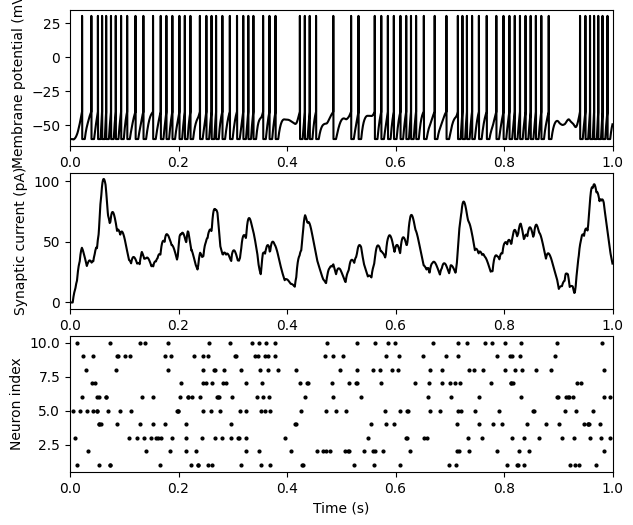

In [21]:
# 結果表示
t = np.arange(nt)*dt
plt.figure(figsize=(7, 6))

plt.subplot(3,1,1)
plt.plot(t, voltage[0], color="k")
plt.xlim(0, nt * dt)
plt.ylabel('Membrane potential (mV)')

plt.subplot(3,1,2)
plt.plot(t, current[0], color="k")
plt.xlim(0, nt * dt)
plt.ylabel('Synaptic current (pA)')

plt.subplot(3,1,3)
for i in range(num_in):
    plt.plot(t, x[:, i] * (i+1), 'ko', markersize=2)
plt.xlabel('Time (s)')
plt.ylabel('Neuron index')
plt.xlim(0, nt * dt)
plt.ylim(0.5, num_in+0.5)
plt.show()

Text(0, 0.5, 'current (pA)')

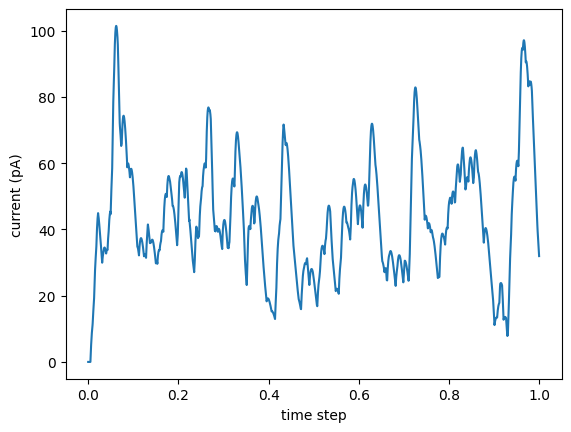

In [22]:
plt.plot(t, np.sum(single_neuron_current[:, 0, :], axis = 0))
plt.xlabel("time step")
plt.ylabel("current (pA)")

Text(0, 0.5, 'current (pA)')

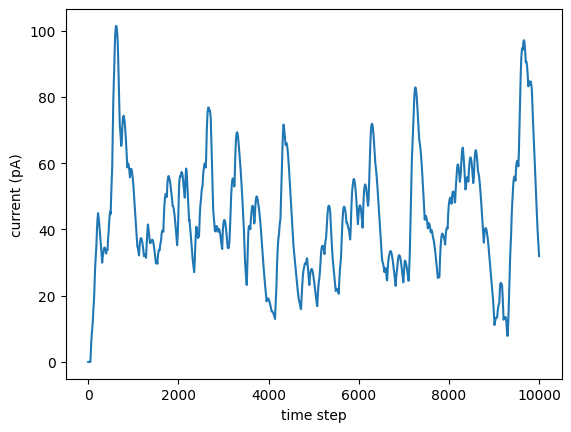

In [23]:
plt.plot(t / dt, np.array(response.iloc[:, 1:]).sum(axis=1))
plt.xlabel("time step")
plt.ylabel("current (pA)")

In [29]:
lif_neuron_membrane_potential_path = "C:/Users/Micro/Desktop/MainResearch/SNN-deployment/network-simulation/data/logs/lif_neuron.v"
lif_neuron_membrane_potential = pd.read_csv(lif_neuron_membrane_potential_path)
lif_neuron_membrane_potential

,t\id,0,1,2,3,4,5,6,7,8,9
0,0,-60.0000,-60.0000,-60.0000,-60.0000,-60.0000,-60.0000,-60.0000,-60.0000,-60.0000,-60.0000
1,1,-60.0500,-60.0500,-60.0500,-60.0500,-60.0500,-60.0500,-60.0500,-60.0500,-60.0500,-60.0500
2,2,-60.0995,-60.0995,-60.0995,-60.0995,-60.0995,-60.0995,-60.0995,-60.0995,-60.0995,-60.0995
3,3,-60.1485,-60.1485,-60.1485,-60.1485,-60.1485,-60.1485,-60.1485,-60.1485,-60.1485,-60.1485
4,4,-60.1970,-60.1970,-60.1970,-60.1970,-60.1970,-60.1970,-60.1970,-60.1970,-60.1970,-60.1970
...,...,...,...,...,...,...,...,...,...,...,...
9995,9995,-47.7487,-47.7487,-47.7487,-47.7487,-47.7487,-47.7487,-47.7487,-47.7487,-47.7487,-47.7487
9996,9996,-47.5929,-47.5929,-47.5929,-47.5929,-47.5929,-47.5929,-47.5929,-47.5929,-47.5929,-47.5929
9997,9997,-47.4409,-47.4409,-47.4409,-47.4409,-47.4409,-47.4409,-47.4409,-47.4409,-47.4409,-47.4409
9998,9998,-47.2926,-47.2926,-47.2926,-47.2926,-47.2926,-47.2926,-47.2926,-47.2926,-47.2926,-47.2926


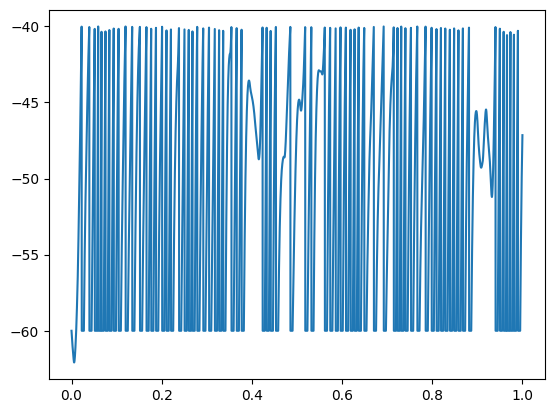

In [30]:
plt.plot(np.arange(nt) * dt, lif_neuron_membrane_potential.iloc[:, 1])

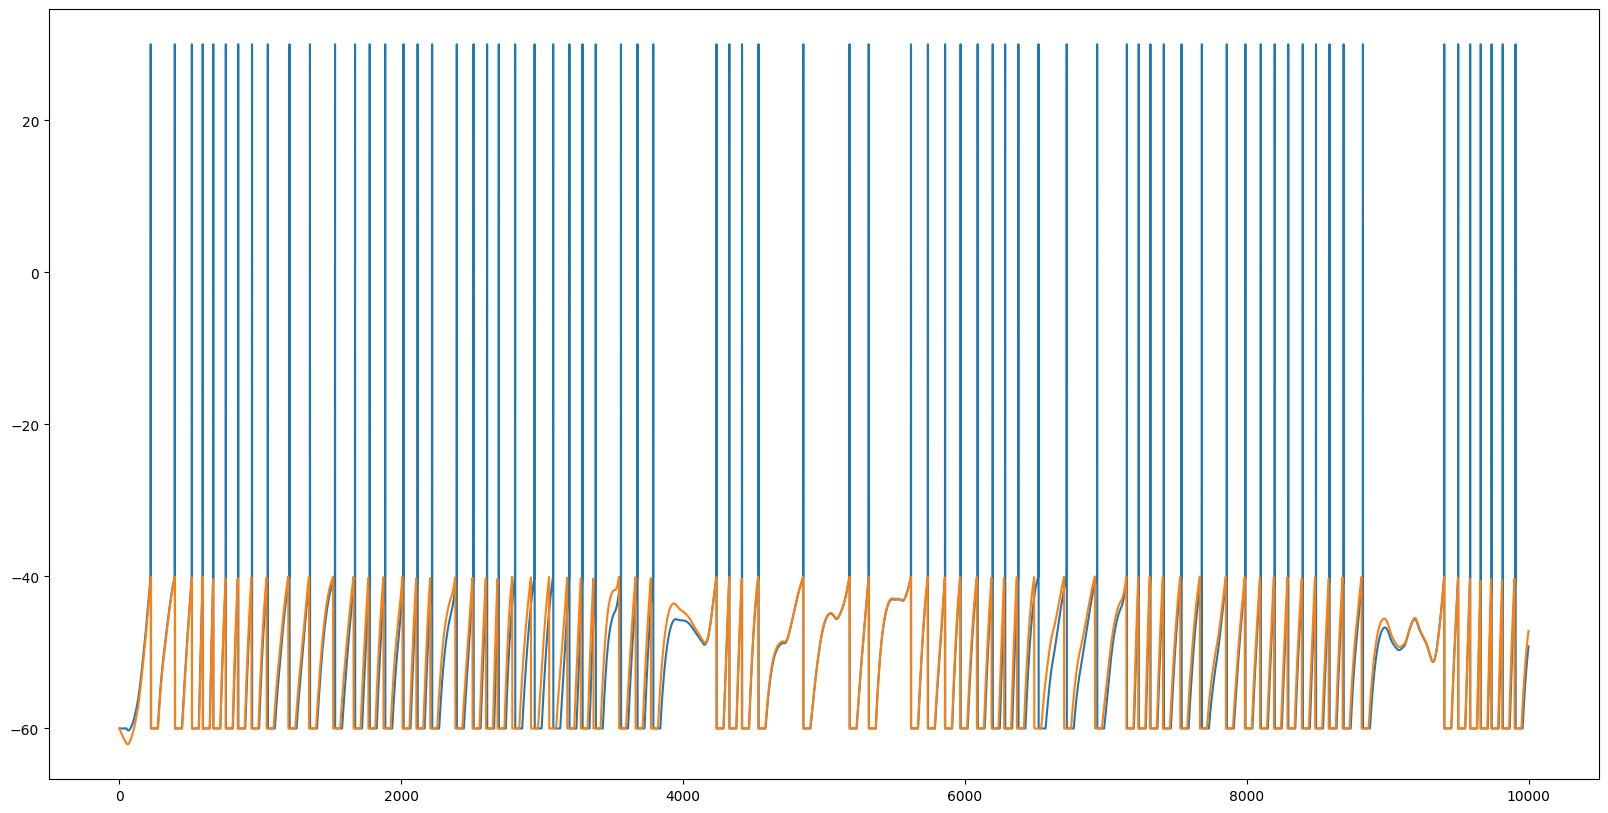

In [32]:
plt.figure(figsize=(20, 10))
plt.plot(np.arange(nt), voltage[0])
plt.plot(np.arange(nt), lif_neuron_membrane_potential.iloc[:, 2])